# **Read the Data**

In [1]:
import numpy as np
import os
import xarray as xr
import datetime
import datetime
from datetime import datetime
from datetime import timedelta
import pandas as pd
from shapely.geometry import Polygon, Point
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


input_file_data="./ERA_1degree_Daily_2000-2020_allvars2.nc"
input_file_labels="./discharge_lobith_daily.xlsx"

def read_data(input_file_data,input_file_labels):
    
    start_date=datetime(2000,1,1)
    end_date=datetime(2021,1,1)
    
    ds = xr.open_dataset(input_file_data)
    labels=pd.read_excel(input_file_labels)
    #align labels and input data in the time dimension
    labels=labels[np.logical_and(labels['datetime']>=start_date,labels['datetime']<end_date)]
    labels=np.array(labels['Q'])
    
    return ds,labels

#load input data and corresponding labels with daily resolution
#variable names: tp-> total precipitation t2m-> 2 meters temperature swvl1 -> Volumetric soil water layer 1
data,labels=read_data(input_file_data,input_file_labels)

#eliminate first longitude which contains nans
data=data.sel(latitude=slice(46.0, 53.0), longitude=slice(4, 12))

#time_line of the data in datetime format
time_line=np.array([datetime.utcfromtimestamp(date.astype('datetime64[s]').astype('int')) for date in np.array(data['time'])])

print(time_line.shape)
print(labels.shape)

(7671,)
(7671,)


C:\Users\areti\AppData\Local\Temp\ipykernel_15472\3642820991.py:40: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  time_line=np.array([datetime.utcfromtimestamp(date.astype('datetime64[s]').astype('int')) for date in np.array(data['time'])])


In [2]:
data

<xarray.Dataset> Size: 27MB
Dimensions:    (time: 7671, latitude: 8, longitude: 9)
Coordinates:
  * time       (time) datetime64[ns] 61kB 2000-01-01 2000-01-02 ... 2020-12-31
  * latitude   (latitude) float64 64B 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0
  * longitude  (longitude) int32 36B 4 5 6 7 8 9 10 11 12
Data variables:
    tp         (time, latitude, longitude) float64 4MB ...
    t2m        (time, latitude, longitude) float64 4MB ...
    swvl1      (time, latitude, longitude) float64 4MB ...
    lai_hv     (time, latitude, longitude) float64 4MB ...
    lai_lv     (time, latitude, longitude) float64 4MB ...
    pev        (time, latitude, longitude) float64 4MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

# **Plot January Mean**

In [3]:
#function to select all the samples in January 2020 (for the 3 variables tp,t2m,swl1) given in input 
#the era5 dataset and the timeline. The function returns the data in numpy format for the 3 variables separately

def select_January_data(data,time_line):
    tp_January = data['tp'].sel(time=slice('2020-01-01T00:00:00.000000000','2020-01-31T00:00:00.000000000')).values
    t2m_January = data['t2m'].sel(time=slice('2020-01-01T00:00:00.000000000','2020-01-31T00:00:00.000000000')).values
    swvl1_January = data['swvl1'].sel(time=slice('2020-01-01T00:00:00.000000000','2020-01-31T00:00:00.000000000')).values 

    #to implement
    
    return tp_January,t2m_January,swvl1_January

#function to plot the Jan 2020 mean given in input the dataset and the time_line
def plot_monthly_mean(data,time_line, variable, index,units, cmap):

     
    cm1 = ax[i].pcolormesh(data.longitude, data.latitude, data.values, cmap = f'{cmap}',transform = ccrs.PlateCarree())
    ax[i].set_title(f'January 2020 mean {variable}', fontsize=15)
    
    #map features
    gl = ax[i].gridlines(crs = crs, color = 'white', draw_labels = True,  linestyle ='--',linewidth=0.3,zorder=9)
    gl.xlabel_style = {'fontsize': 12}
    gl.ylabel_style = {'fontsize': 12}
    gl.top_labels   = False
    gl.right_labels = False
    plt.colorbar(cm1, ax=ax[i], label = f'{units}',shrink=0.4)
    ax[i].add_feature(cfeature.COASTLINE, linewidth = 1,zorder=7)
    
    
    #to implement
    return
    

In [4]:
tp_January, t2m_January, swvl1_January = select_January_data(data,0)

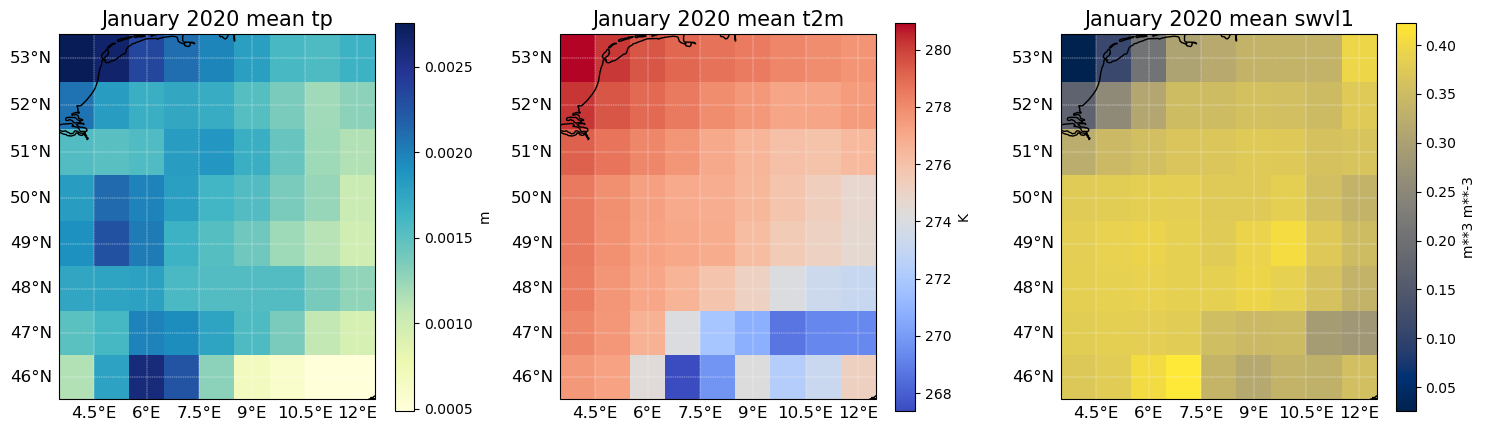

In [5]:
#Plottting the three variables (mean values of January 2020)
projection = ccrs.Miller()
#Specify CRS
crs = ccrs.PlateCarree()  

variables = ['tp','t2m','swvl1']
c = ['YlGnBu','coolwarm','cividis'] #cmaps

#plots
#Specify projection
projection = ccrs.Miller()
#Specify CRS
crs = ccrs.PlateCarree()  

fig, ax  = plt.subplots(ncols=3,nrows=1, figsize=(15,10), subplot_kw={'projection': projection})

i =0 
for var in variables:
    
    ds = data[var].sel(time=slice('2020-01-01T00:00:00.000000000','2020-01-31T00:00:00.000000000')) #select sice for month
    units = data[var].units #get unist for colorbar
    ds = ds.mean(dim='time') #create monthly mean 
    plot_monthly_mean(data=ds,time_line=time_line, variable = var, index=i, units = units,cmap=c[i])
    #print(ds)
    i+=1
    
plt.tight_layout()
plt.show()    

Questions: Why do We want the January mean 2020?

# **Determine Time Delay**

In [6]:
#determine lagged correlation
from scipy.stats import pearsonr

#function to compute the region average of precipition P and the lagged correlation between the region average 
#and the corresponding discharge values given in input the ERA5 dataset, the river discharge and the lag. 
#This function can be used to compute the correlation for different lags to then plot the results
def compute_lag_correlation(data,Q,lag):
    #select the total precipitation
    data = data['tp']
    
    #correctly calculating the spatial mean 
    weights = np.cos(np.deg2rad(data.latitude))
    weights.name = "weights"
    weights

    data_weighted = data.weighted(weights)
    data_mean = data_weighted.mean(("longitude", "latitude"))

    pcor = []
    #applying the different lags an compute pearson correlation 
    for lag in lag_values:
        x = data_mean[:-lag] 
        y = labels[lag:]
        r, p  = pearsonr(x,y)
        pcor.append(r)
        
    #plot
    fig = plt.figure(figsize=(7,4))
    plt.title('Laged Correlation P-Q', fontsize=15)
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Lag Correlation', fontsize=12)
    plt.scatter(lag_values,pcor, color='red')
    plt.grid(True)
    
    #deterimen the maximum 
    lagged_correlation = max(pcor) 
    lagged_days = np.argmax(pcor)
   
    return lagged_correlation, lagged_days

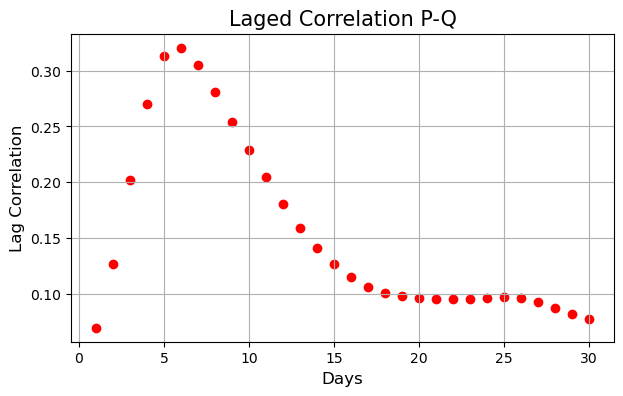

In [7]:
lag_values = np.arange(1,31,1) #Trying out 1 to 30 days of lag
lag_cor, lag_days = compute_lag_correlation(data=data,Q=labels,lag=lag_values)

# **Preprocessing functions**

We have data from 2000 to 2020. We need to split that fro data to use in the trainng phase (training and validation) as well as testing.

For testing we are using 2016-01-01 to 2020-12-31, hence 5 years (25% of the whole data) 

Therefore are using 2000-01-01 to 2015-12-31 during the training. 

Validation : 2011-01-01 to 2015-12-31 ( approx 25% of whole data)
Training   : 2000-01-01 to 2010-21-31 (approx 50% of the whole data) 

In [53]:
#function to select variables from the ERA5 dataset, given in input the dataset and a list containing 
#variables names, the function return the data in numpy format

def prepare_data(data,variables):

    arrays=[]
    #loop through the variable list 
    for var in variables:
        ds = data[var].values
        arrays.append(ds)
        
    X = np.stack(arrays, axis=3) #stacking the arrays on top of each otehr for each value shape: (time, lat, lon, var)
    #to implement
        
    return X

#function to split data in train/test given in input the data in numpy with corresponding labels and time_line.
#Return training set, validation set, training labels, validation labels, training timeline and 
#validation timeline
def train_test_split(X,labels,time_line):
    #to implement
        def time_split(start, end, time_line):
            'function that selects a subset based on satrt and end date'
            time_mask = (time_line >= start) & (time_line <= end)
            index = np.where(time_mask)
            time = time_line[index]
            return time, index
        #split dates 
        start_train =  datetime(2000, 1, 1, 0, 0)
        end_train   =  datetime(2010, 12, 31, 0, 0)
        
        start_valid =  datetime(2011, 1, 1, 0, 0)
        end_valid   =  datetime(2015, 12, 31, 0, 0)
        
        start_test =  datetime(2011, 1, 1, 0, 0)
        end_test   =  datetime(2016, 1, 1, 0, 0)
        #spli the actual sets basedon teh dates
        time_line_training , ind_train = time_split(start_train, end_train, time_line)
        time_line_validation , ind_valid   = time_split(start_valid, end_valid, time_line)
        time_line_testing  , ind_test  = time_split(start_test, end_test, time_line)
        #vreturn variables we want 
        X_train = X[ind_train,:,:,:][0]
        X_validation = X[ind_valid,:,:,:][0]
        y_train = X[ind_train,:,:,:][0]
        y_validation = X[ind_valid,:,:,:][0]
        return X_train,X_validation,y_train,y_validation,time_line_training,time_line_validation

#function to normalize data based on training data mean and std given in input the dataset we want to use 
#to compute mean and std (X_mean_std) and the data we want to normalize (X)
def normalize_data(X_mean_std,X):
  
    mean = np.mean(X_mean_std, axis=0)  # mean
    std = np.std(X_mean_std, axis=0)    # std
    
    # Avoid divide-by-zero
    std[std == 0] = 1e-6
    
    # normalize
    X_normalized = (X - mean) / std
    
    return X_normalized

#function to normalize the labels (discharge) based on training data labels, given in input labels to use to 
#compute mean and std (labels_mean_std) and the labels to normalize (labels).
#Return normalized labels and mean and std to reverse normalization
def normalize_labels(labels_mean_std,labels):
    #to implement
    train_mean= np.mean(labels_mean_std, axis=0)  # mean
    train_std= np.std(labels_mean_std, axis=0)    # std
    
    # Avoid divide-by-zero
    train_std[train_std == 0] = 1e-6
    
    # normalize
    labels_normalized = (labels - train_mean) / train_std
    
    return labels_normalized,train_mean,train_std
    

#function to define our samples for training using a rolling time window of dimension t. The dimension of each 
#sample, must be [t,lat,lon,variables] if you use tensorflow, [variables,t,lat,lon] if you use pytorch.
#In input the data we want to transform in mupy format with the corresponding labels and the dimension of 
#the time window. Return transformed samples and corresponding labels aligned in time with new data
def prepare_running_window_samples(X,labels,window_dimension):
    X = X.transpose(3, 0, 1, 2) #(var,t,lat,lon)
    n_timesteps = X.shape[1]
    n_samples = n_timesteps - window_dimension + 1
    
    running_dataset = []
    labels_aligned = []
    
    for i in range(n_samples):
        # Extract a window of length 'window_dimension' from X
        window = X[:, i : i + window_dimension, :, :]   # shape: (window_dimension, lat, lon, variables)
        running_dataset.append(window)
    
        # Take the label corresponding to the last time step in the window
        label = labels[i + window_dimension - 1]
        labels_aligned.append(label)
    
    # Convert lists to NumPy arrays
    running_dataset = np.array(running_dataset)
    labels_aligned = np.array(labels_aligned)
    return running_dataset,labels_aligned

#function to select the winter and summer period data from the validation data, given in input the validation data
#in numpy format the validation labels and the validation data time_line. Return the Validation data corresponding
#to summer and winter with corresponding labels
def select_summer_winter_period(X,labels,time_line):
    
    
    return X_summer,X_winter,labels_summer,labels_winter
        
    
variables=['tp', 't2m', 'swvl1'] #list of variables names
#t= #define time window dimension
X=prepare_data(data,variables)

X_train,X_validation,labels_train,labels_validation,time_line_train,time_line_validation=train_test_split(X,
labels,time_line)
print(X_train.shape,X_validation.shape,labels_train.shape,labels_validation.shape)

labels_train_scaled,mean_labels,std_labels=normalize_labels(labels_train,labels_train)
print(labels_train_scaled.shape)

X_train_normalized=normalize_data(X_train,X_train)
X_validation_normalized=normalize_data(X_train,X_validation)
print(X_train_normalized.shape)
print(X_validation_normalized.shape)

X_train_normalized_sliced,labels_train_sliced=prepare_running_window_samples(X_train_normalized,
labels_train_scaled,5)
X_validation_normalized_sliced,labels_validation_sliced=prepare_running_window_samples(X_validation_normalized,
labels_validation,5)

print(X_train_normalized_sliced.shape)
print(X_validation_normalized_sliced.shape)
print(labels_train_sliced.shape)
print(labels_validation_sliced.shape)   

(4018, 8, 9, 3) (1826, 8, 9, 3) (4018, 8, 9, 3) (1826, 8, 9, 3)
(4018, 8, 9, 3)
(4018, 8, 9, 3)
(1826, 8, 9, 3)
(4014, 3, 5, 8, 9)
(1822, 3, 5, 8, 9)
(4014, 8, 9, 3)
(1822, 8, 9, 3)


# **Definition of Pytorch functions**

In [ ]:
import torch
#define initial hyper-parameters and device gpu. On mac is mps, change it for windows

device = torch.device("mps" if torch.cuda.is_available() else "cpu")
batch_size=10
lr=10**(-4)
n_epochs=20

In [ ]:
from torch.utils.data import Dataset, DataLoader

#define your custom dataset 
class CustomDataset(Dataset):

    def __init__(self, X, labels):

    #initialize the dataset with data and corresponding labels
    #to implement

    def __len__(self):
        
        #return len of your dataset
        #to implement

    def __getitem__(self, idx):
        
        #return the sample in your dataset corresponding to index idx


In [ ]:
#define the network
import torch
import torch.nn as nn

#you need to define a network with 2 Conv3d layers, each one with 16 output channels, kernel_size=3 and padding=1.
#After each Conv3d layer ReLU activation function. After the 2 Conv3d layer a MaxPool3d layer with kernel size
#(2,1,1) and stride (2,1,1) (perform maxpooling only in time direction). After pooling flatten the data then
#MLP (Multy layer perceptron) with 3 hidden layers with n_neurons 256, 128 and 64. Relu after each hidden layer.
#Output layer with dimension one and linear activation function.

class Conv3DNet(nn.Module):
    def __init__(self,input_dimensions):
        super(Conv3DNet, self).__init__()
        
        self.conv1 = nn.Conv3d(
            in_channels=input_dimensions[0], 
            out_channels=16, 
            kernel_size=3, 
            padding=1
        )
        
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv3d(
            in_channels=16, 
            out_channels=16, 
            kernel_size=3, 
            padding=1
        )
        
        self.relu2 = nn.ReLU()

        self.pool = nn.MaxPool3d(
            kernel_size=(2,1,1), 
            stride=(2,1,1)
        )

        # Calculate the flattened size after conv & pool
        dummy_input = torch.zeros(1, *input_dimensions)
        dummy_output = self.pool(self.relu2(self.conv2(self.relu1(self.conv1(dummy_input)))))
        self.flattened_size = dummy_output.numel()

        # MLP layers
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(256, 128)
        self.relu4 = nn.ReLU()

        self.fc3 = nn.Linear(128, 64)
        self.relu5 = nn.ReLU()

        self.output_layer = nn.Linear(64, 1)  # Linear output

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.pool(x)

        x = x.view(x.size(0), -1)  # flatten

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        x = self.relu4(x)

        x = self.fc3(x)
        x = self.relu5(x)

        x = self.output_layer(x)
        return x
        
        
    
#function to train your model. Define the train loop and save after each epoch the mse with respect to normalized
#labels and mean absolute error with respect to original labels (reverse transformation). In input 
#training data in numpy format, training dataloader, learning rate and number of epochs.
#Returned trained model, a list containing loss per epoch and a list containing mae per epoch

def train(data,dataloader,lr,n_epochs):
    #define loss function and optimizer 
    #to implement
    
    #define the training loop remember to save loss and mae at each epoch in the correct way
    for epoch in range(n_epochs):
        #to implement

        for i, data in enumerate(dataloader):
            # Iterate over the batches and save loss and mae to then compute loss and mae per epoch
            #to implement
    
    return model,loss_epochs,mae_epochs
    
#convert training data to tensors
X_train_torch=torch.from_numpy(X_train_normalized_sliced).float()
labels_train_torch=torch.from_numpy(labels_train_sliced).float()

#define custom dataset using training data
dataset=CustomDataset(X_train_torch,labels_train_torch)
#define dataloader using the custom dataset
dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=False)

model,loss_epochs,mae_epochs=train(X_train_torch,dataloader,lr,n_epochs)

In [ ]:
#convert validation data to tensors
X_validation_torch=torch.from_numpy(X_validation_normalized_sliced).float()
labels_validation_torch=torch.from_numpy(labels_validation_sliced).float()
#define validation custom dataset
dataset=CustomDataset(X_validation_torch,labels_validation_torch)
#define validation dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=False)

#this function return predictions and real labels given in input the trained model and a dataloader 
#containing the test data with corresponding labels

def predict(model,dataloader):
    
    #to implement
    
    return predictions, true_labels

predictions,true_labels=predict(model,dataloader)
    